# 0-60mph 🏃 with CMIP6 datasets in the cloud

## Learning goals
- Searching and selecting CMIP6 datasets from the cloud catalog
- Simple plots for multiple models

## Caveats
1. This notebook is exectuable locally
2. This notebook does not demonstrate the use of dask for parallelism.
3. Anonymous execution of [Pangeo gallery](http://gallery.pangeo.io/) notebooks is disabled for now due to cryptomining abuse. That means you cannot execute those notebooks but you can definitely view them.
4. If you want to work more seriously with the data sign up to access the [pangeo cloud deployments](https://pangeo.io/cloud.html).

## Reading data

The data are stored in the cloud.  We  do not interact with the "files" (or "assets") directly. Instead we access them through a catalog that contains all the information needed to read the data.

Here we use the catalog functionality provided by [intake-esm](https://intake-esm.readthedocs.io/en/stable/).

In [3]:
import intake
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cmip6_preprocessing.preprocessing import combined_preprocessing


# This file points to the Google Cloud Storage pangeo catalog
# url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

# There is a mirror on Amazon S3 (this currently still contains 
# some retracted datasets, so we currently recommend the GCS version for actual science workflow)
url = "https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json"

col = intake.open_esm_datastore(url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,60


What you see here is a catalog of many different [zarr](https://zarr.readthedocs.io/en/stable/) stores in the cloud (currently 515388 😳). 
Each of these datasets represents different models, experiments, variables and so on. These different attributes - often called 'facets' - are described by a fixed [vocabulary](https://github.com/WCRP-CMIP/CMIP6_CVs). As an example the different models are given by the `source_id` facet. You can see above that there are 88 models in the catalog.

>For this demonstration we take advantage of [intake-esm](https://github.com/intake/intake-esm), which gives us this nice representation of the catalog above and some convenient search and load utilities which we demo below. 

>This is however purely optional. There are [multiple ways](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html) of accessing the data in the cloud, and most steps demonstrated below work with either of them.

Lets see which models are available

In [4]:
# `.df` method exposes a pandas dataframe, which you can inspect as usual
sorted(col.df['source_id'].unique())

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-HR',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'CESM1-1-CAM5-CMIP5',
 'CESM1-WACCM-SC',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CIESM',
 'CMCC-CM2-HR4',
 'CMCC-CM2-SR5',
 'CMCC-CM2-VHR4',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'E3SM-1-0',
 'E3SM-1-1',
 'E3SM-1-1-ECA',
 'EC-Earth3',
 'EC-Earth3-AerChem',
 'EC-Earth3-CC',
 'EC-Earth3-LR',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'EC-Earth3P',
 'EC-Earth3P-HR',
 'EC-Earth3P-VHR',
 'ECMWF-IFS-HR',
 'ECMWF-IFS-LR',
 'FGOALS-f3-H',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-AM4',
 'GFDL-CM4',
 'GFDL-CM4C192',
 'GFDL-ESM2M',
 'GFDL-ESM4',
 'GFDL-OM4p5B',
 'GISS-E2-1-G',
 'GISS-E2-1-G-CC',
 'GISS-E2-1-H',
 'GISS-E2-2-G',
 'GISS-E2-2-H',
 'HadGEM3-GC31-HM',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-LM',
 'HadGEM3-GC31-MM',
 'ICON-ESM-LR',
 'IITM-ESM',
 'INM-CM4-8',
 'I

One rarely uses the full archive, and usually we want to search for a subset of data. 

We can achieve this by [searching/subsetting](https://intake-esm.readthedocs.io/en/stable/user-guide/search.html) the catalog.

So for instance, if we only want to look at the historical forcing experiment, we can search for it like this:

In [5]:
cat = col.search(experiment_id = 'historical')
cat

,unique
activity_id,1
institution_id,31
source_id,65
experiment_id,1
member_id,201
table_id,34
variable_id,648
grid_label,9
zstore,86096
dcpp_init_year,0


You can now see that there is in fact only one experiment left in the subset catalog.

Thats still a lot of data (look at `zstore`), so lets search for several facets at the same time to get this down to a bunch of datasets we can use in the tutorial.

Lets pick monthly output (`table_id='Omon'`) and the native grid (`grid_label='gn'`) for three models picked from the list above. For the example we are only going to look at the ocean salinity `variable_id='so'` variable.

You can explore other variables and their CMIP names [here](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271).

In [6]:
cat = col.search(
    # We are chosing only the experiments with the historical forcing
    experiment_id = 'historical',
    # Chose the 3d ocean salinity variable
    variable_id='so',
    # Monthly averages
    table_id='Omon',
    # On the native model grid
    grid_label='gn',
    # chose just three models from above as example
    source_id=['MPI-ESM1-2-HR', 'CanESM5-CanOE', 'GFDL-ESM4']
)
cat

,unique
activity_id,1
institution_id,3
source_id,3
experiment_id,1
member_id,13
table_id,1
variable_id,1
grid_label,1
zstore,13
dcpp_init_year,0


Ok time to load the datasets into a dictionary. Note that this is only 'lazily' loading the data, which means we only access the metadata, and the full output is only loaded when we perform a computation!

`datasets_dict` is a dictionary mapping a long unique namelike`'CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1.Omon.so ...` to an xarray Dataset that represent the model output.

Note that this step will be a little slow if executed on your laptop; it is a lot faster in the cloud.

The `preprocess` argument enables you to apply any function to each dataset. We are using the wrapper function `combined_preprocessing` here to avoid issues with different naming etc ([more info on cmip6_preprocessing](https://cmip6-preprocessing.readthedocs.io/en/latest/tutorial.html))

> cmip6_preprocessing works well with intake-esm, but this function can be applied to any CMIP6 xarray dataset (e.g. loaded from local netcdfs.


In [7]:
datasets_dict = cat.to_dataset_dict(
    storage_options={'anon':True}, # only needed for S3 not for GCS 
    zarr_kwargs={'use_cftime':True,'consolidated':True},
    aggregate=False,
    preprocess=combined_preprocessing
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Here is the first dataset for inspection

In [8]:
list(datasets_dict.values())[0]

<xarray.Dataset>
Dimensions:        (x: 360, y: 291, lev: 45, bnds: 2, time: 1980, vertex: 4)
Coordinates: (12/14)
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
    lat            (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev            (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(45, 2), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    ...             ...
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 291, 360), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 291, 360), meta=np.ndarray>
Data variables:
    so             (time, lev, y, x) float32 dask.array<chunksize=(7, 45, 291, 360), meta=np.ndarray>
Attributes: (12/58)
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-his02
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variant_label:               r2i1p2f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/f324d54b-40cc-4f21-9acc-ac62142...
    version_id:                  v20190429
    intake_esm_varname:          None
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5-CanOE.historical.r2i1p2f1...

## Visualize the data

Now lets do something really simple: Plot the surface salinity at the first timestep using a nice projection from [cartopy](https://scitools.org.uk/cartopy/docs/latest/)

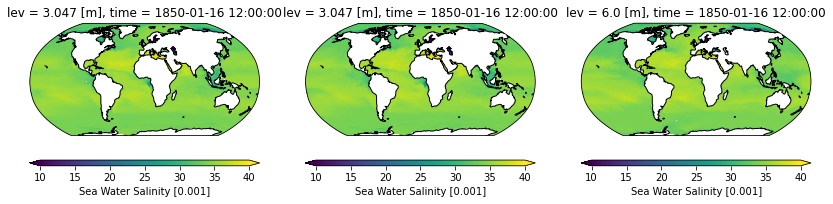

In [9]:
# first set up axes for plotting using matplotlib/cartopy 
fig, axarr = plt.subplots(
    # 3 columns
    ncols=3,
    # figure size in inches
    figsize=[14,3],
    # projection for the plot
    subplot_kw={'projection':ccrs.Robinson()}
)

# loop over each dataset and associated axes
for ds, ax in zip(datasets_dict.values(), axarr.flat):
    ds.isel(time=0, lev=0).so.plot(
        ax=ax,
        infer_intervals=False,
        x='lon',
        y='lat',
        transform=ccrs.PlateCarree(),
        vmax=40,
        vmin=10,
        cbar_kwargs={"orientation": "horizontal", "aspect": 40},
    )
    ax.coastlines()

Now we can select a particular box in the tropical eastern Pacific 
> Bonus points if you are able to mask out the little corner of the Gulf of Mexico with [cmip6_preprocessing](https://cmip6-preprocessing.readthedocs.io/en/latest/regionmask.html)

/Users/juliusbusecke/miniconda/envs/tutorial_osm22_cmip6/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/Users/juliusbusecke/miniconda/envs/tutorial_osm22_cmip6/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large

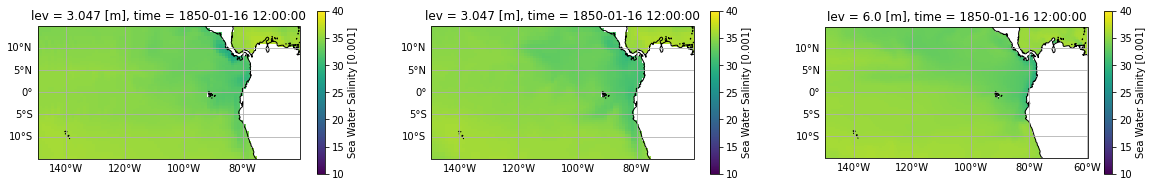

In [10]:
fig, axarr = plt.subplots(
    ncols=3,
    figsize=[20,3],
    subplot_kw={'projection':ccrs.PlateCarree()}
)
for ds, ax in zip(datasets_dict.values(), axarr.flat):
    masked_ds = ds.where(
        (ds.lon > 210) & (ds.lon < 300) & (ds.lat < 15) & (ds.lat > -15), drop=True
    )
    masked_ds.isel(time=0, lev=0).so.plot(
        ax=ax,
        infer_intervals=False,
        x='lon',
        y='lat',
        transform=ccrs.PlateCarree(),
        vmax=40,
        vmin=10,
    )
    ax.coastlines()
    ax.set_extent([masked_ds.lon.min(), masked_ds.lon.max(), -15, 15], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=['bottom', 'left'])
    ax.set_aspect(1.5)

## Some more useful information and examples

That was just a start
- See the [Pangeo gallery](http://gallery.pangeo.io/) for more oceanography examples!
- A blogpost about interpolating tracers to density surfaces https://medium.com/pangeo/vertical-coordinate-transformation-with-pangeo-have-some-pancakes-and-let-xgcm-do-the-work-b0056604d346

## Questions?

You will undoubtedly have some questions as you work through the notebook. 

Bring them up in the chat or at [discourse.pangeo.io](https://discourse.pangeo.io) after the session is done.